In [2]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np

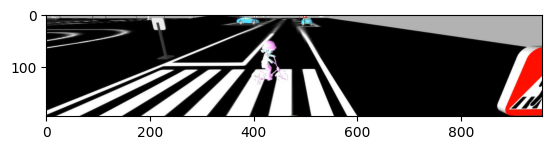

In [12]:
frame = cv2.imread('images/img_test6.png')

h,w,_ = frame.shape
frame = frame[295:490,:,:] #int(w/2):int(w-(w/2-1000))

plt.imshow(frame)

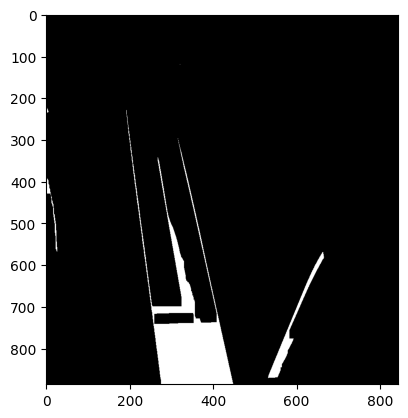

In [5]:
frame = cv2.imread('images/img_test6.png')

h,w,_ = frame.shape
frame = frame[295:490,:,:] #int(w/2):int(w-(w/2-1000))
h1,w1,_ = frame.shape
	
####################birdview
tl = [0, 0]
tr = [w1, 0]
br = [w1, h1]
bl = [0, h1]
corner_points_array = np.float32([tl,tr,br,bl])
h,w,c=frame.shape
width = 2280
height = 1640
imgTl = [0,0]
imgTr = [width,0]
imgBr = [0.7*width,height]
imgBl = [0.583*width,height]
img_params = np.float32([imgTl,imgTr,imgBr,imgBl])

matrix = cv2.getPerspectiveTransform(corner_points_array,img_params)
img_transformed = cv2.warpPerspective(frame,matrix,(width,height))
#####################

img_transformed=img_transformed[int(0.46*height):height,int(0.46*width):int(0.83*width),:]
ht,wt,c=img_transformed.shape

#lọc màu trắng dựa vào RGB
lower_white = np.array([200,200,200], dtype=np.uint8)
upper_white = np.array([255,255,255], dtype=np.uint8)

mask = cv2.inRange(img_transformed, lower_white, upper_white)

# lọc nhiễu tường , gom vạch đi đường
dilate = cv2.dilate(mask, None, iterations=9)
mask = cv2.erode(dilate, None, iterations=10)

mask1 = mask.copy()
sampling = mask1[int(ht*0.89):int(0.98*ht),:]
contours, _ = cv2.findContours(image=sampling, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
normal = []
a = np.zeros_like(sampling)
for cnt in contours:
		x,y,wr,hr = cv2.boundingRect(cnt)
		area2 = cv2.contourArea(cnt)
		if area2 < 1000 and area2 >= 180: #đường bình thường
			normal.append(int(x+wr/2))
			cv2.circle(img_transformed, (int(x+wr/2),int(ht*0.935)), 5, (250,0,250), 15)
		elif area2 < 180: #nét đứt
			cv2.circle(a, (int(x+wr/2),int(y+hr/2)), 5, (250,0,250), 45) #gom các loại nét đứt 
		else:  #đường độ rộng lớn
			cv2.circle(img_transformed, (int(x),int(ht*0.935)), 5, (250,0,250), 15)
			cv2.circle(img_transformed, (int(x+wr),int(ht*0.935)), 5, (250,0,250), 15)
			normal.append(int(x+wr))
			normal.append(int(x))
contours2, _ = cv2.findContours(image=a, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
for cnt in contours2:
		x,y,wrs,hrs = cv2.boundingRect(cnt)
		area3 = cv2.contourArea(cnt)
		if area3 > 3000: # nét đứt gần
			normal.append(int(x+wrs/2))
			cv2.circle(img_transformed, (int(x+wrs/2),int(ht*0.935)), 5, (0,0,250), 15)
normal = sorted(normal, reverse=True)[:2]
b = None

if len(normal) == 2: 
	if abs(normal[0]-normal[1])>200: # vạch đi đường
		b =  int(int((normal[0]+normal[1])/2) + abs(normal[0]-normal[1])/4)
	else:
		b = int((normal[0]+normal[1])/2)
elif len(normal)  == 1: #một làn
	b = normal[0] - 50
if b is not None:
	cv2.circle(img_transformed, (b,int(ht*0.935)), 5, (250,0,0), 15)
# cv2.imshow('mask',mask)
# cv2.imshow('res',sampling)
plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
# cv2.imshow('ss',img_transformed)

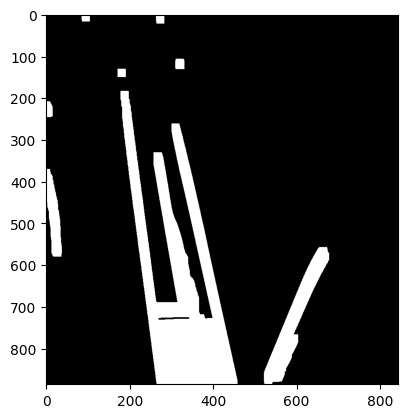

In [6]:
plt.imshow(dilate, cmap='gray', vmin=0, vmax=255)


## Normal

In [5]:
import time
import numpy as np
from scipy import stats
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist

from collections import Counter

In [54]:
class Lane_Detection:
    def __init__(self):
        self.__width = 220

    def __call__(self, image):
        image = self.image_processing(image)

        ####### Edges Detection #######
        edges = self.edges_detection(image)

        ####### Lane Processing #######
        center = self.lane_processing(edges)

        return center, self.__img_show
    
    def image_processing(self, image):
        image = cv2.resize(image, (640,360))
        self.__img_show = image.copy()
        image = image[250:,:,:]

        return image

    def edges_detection(self, image):
        img = cv2.GaussianBlur(image, (7,7), 0)
        # hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        _, mask = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
        edges = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        # edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=10)
        edges = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel)

        return edges

    def lane_processing(self, edges):
        img_array = np.array(edges, dtype = int)
        x_left = []
        y_left = []
        x_right = []
        y_right = []

        for i in range(edges.shape[0]):
            row = img_array[i,:]
            try:
                ####### Tìm lane trái - lane phải #######
                index = np.where(row > 0)[0]
                min_index = np.min(index)
                max_index = np.max(index)

                ####### Điều kiện với đường 2 làn (self.__width là độ rộng đường của 1 làn) #######
                if max_index - min_index >= self.__width:
                    ####### CLUSTERING #######
                    class_id = self.cluster(index) # class từ 0->n
                    
                    ####### Vạch đi bộ có 9 vạch -> đổi lại lane trái bằng lane chính giữa của vạch đi bộ là line thứ 5 #######
                    if max(class_id) == 9: 
                        new_min_index = index[class_id==5].ravel()[0]

                        if max_index - new_min_index <= self.__width:
                            min_index = new_min_index

                        else:
                            continue
                    
                    ####### Vạch đi bộ có noise line của biển báo => xử lý lane trái như TH trên còn lane phải trừ đi 2 class id #######
                    elif max(class_id) > 9:
                        end_cluster = index[class_id==max(class_id)].ravel()
                        if end_cluster[-1] >= 600:
                            new_max_index = index[class_id==max(class_id)-1].ravel()[-1]
                            new_min_index = index[class_id==5].ravel()[0]
                            
                            if new_max_index - new_min_index <= self.__width:
                                max_index = new_max_index
                                min_index = new_min_index

                            else:
                                continue
                        else: 
                            continue
                    
                    ####### Đường có 3 lane trở lên => lane trái = lane phải - 1 lane #######
                    elif max(class_id) > 2:
                        if max_index <= 600:
                            new_min_index = index[class_id==max(class_id)-1].ravel()[0]

                            if 100 <= max_index - new_min_index <= self.__width:
                                min_index = new_min_index
                            else: 
                                continue
                        else: 
                            continue

                    ####### Đường có 2 lane #######
                    else:
                        y_right.append(i)
                        x_right.append(max_index)
                        continue

                if max_index >= 300:
                    y_right.append(i)
                    x_right.append(max_index)

                if min_index <= 300:
                    y_left.append(i)
                    x_left.append(min_index)

            except:
                pass
        
        ######## Linear Regression ########
        try:
            a_r, b_r, r_r, p_r, std_err_r = stats.linregress(x_right, y_right)
            pre_r = (45-b_r)/a_r

            if len(x_left) != 0:
                a_l, b_l, r_l, p_l, std_err_l = stats.linregress(x_left, y_left)
                pre_l = (45-b_l)/a_l
            else:
                pre_l = pre_r - (self.__width - 60)

            ######## TH đường 1 làn nhưng rộng ########
            if pre_r - pre_l > self.__width + 50 or pre_r - pre_l <= 0:
                pre_l = pre_r - (self.__width - 60)

            center = (pre_r + pre_l)/2

            ######## Visualize ########
            cv2.circle(self.__img_show,(int(center), 295), 5, (255,0,0),3)
            cv2.circle(self.__img_show,(int(pre_r), 295), 5, (255,0,0),3)
            cv2.circle(self.__img_show,(int(pre_l), 295), 5, (255,0,0),3)
            cv2.line(self.__img_show, (int(pre_r), 295), (int(pre_l), 295),(0,0,255), 3)
            
        except:
            center = 320
        
        return center

    def cluster(self, index):
        X = index.reshape(-1, 1)

        Z = ward(pdist(X))
        y = fcluster(Z, t=50, criterion='distance')
        
        class_id = np.copy(y)
        counts = Counter(y).values()
        start = 0
        for i, c in enumerate(counts):
            class_id[start:start+c] = i+1
            start += c
        
        return class_id

320


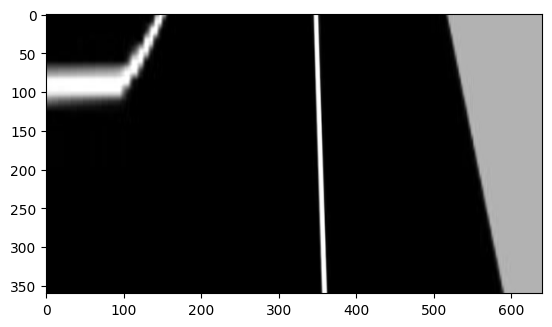

In [56]:
lane_det = Lane_Detection()

image_original = cv2.imread('./img_test7.png')
image_original = image_original[300:450,:, :]

center, img_show = lane_det(image_original)

print(center)
plt.imshow(img_show, cmap='gray', vmin=0, vmax=255)

321.65748821789657


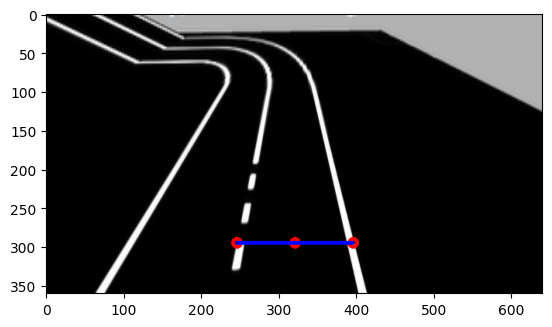

In [10]:
width = 220

image_original = cv2.imread('./img_test10.png')
image_original = image_original[300:450,:, :]

# ********** ********** ********** #
image_original = cv2.resize(image_original, (640,360))
img_show = image_original.copy()

image = image_original[250:,:,:]
img = cv2.GaussianBlur(image, (7,7), 0)

# ********** Filter ********** #
# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
_, mask = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
edges = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=10)
edges = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel)

# ********** Processing ********** #
img_array = np.array(edges, dtype = int)
x_left = []
y_left = []
x_right = []
y_right = []

for i in range(edges.shape[0]):
    row = img_array[i,:]
    try:
        index = np.where(row > 0)[0]
        min_index = np.min(index)
        max_index = np.max(index)
        
        ####### CLUSTERING #######
        if max_index - min_index >= width:
            class_id = cluster(index)
            
            
            ####### Vạch đi bộ #######
            if max(class_id) == 9: 
                new_min_index = index[class_id==5].ravel()[0]

                if max_index - new_min_index <= width:
                    min_index = new_min_index

                else:
                    continue
            
            ####### Vạch đi bộ có noise #######
            elif max(class_id) > 9:
                end_cluster = index[class_id==max(class_id)].ravel()
                if end_cluster[-1] >= 600:
                    new_max_index = index[class_id==max(class_id)-1].ravel()[-1]
                    new_min_index = index[class_id==5].ravel()[0]
                    
                    if new_max_index - new_min_index <= width:
                        max_index = new_max_index
                        min_index = new_min_index

                    else:
                        continue
                else: 
                    continue

            elif max(class_id) > 2:
                if max_index <= 600:
                    new_min_index = index[class_id==max(class_id)-1].ravel()[0]

                    if 100 <= max_index - new_min_index <= width:
                        min_index = new_min_index

                    else: 
                        continue
                
                else:
                    continue
            
            ####### Đường có 2 lane #######
            else:
                y_right.append(i)
                x_right.append(max_index)
                continue
        
        if max_index >= 300:
            y_right.append(i)
            x_right.append(max_index)

        if min_index <= 300:
            y_left.append(i)
            x_left.append(min_index)

    except:
        pass

try:
    a_r, b_r, r_r, p_r, std_err_r = stats.linregress(x_right, y_right)
    pre_r = (45-b_r)/a_r

    if len(x_left) != 0:
        a_l, b_l, r_l, p_l, std_err_l = stats.linregress(x_left, y_left)
        pre_l = (45-b_l)/a_l
    else:
        pre_l = pre_r - (width - 60)
    
    if pre_r - pre_l > width + 10 or pre_r - pre_l <= 0:
        pre_l = pre_r - (width - 60)
        
    center = (pre_r + pre_l)/2
    cv2.circle(img_show,(int(center), 295), 5, (255,0,0),3)
    cv2.circle(img_show,(int(pre_r), 295), 5, (255,0,0),3)
    cv2.circle(img_show,(int(pre_l), 295), 5, (255,0,0),3)
    cv2.line(img_show, (int(pre_r), 295), (int(pre_l), 295),(0,0,255), 3)

except:
    center = 320

print(center)
plt.imshow(img_show, cmap='gray', vmin=0, vmax=255)


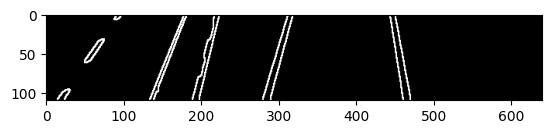

In [34]:
plt.imshow(edges, cmap='gray', vmin=0, vmax=255)


In [4]:
def cluster(index):
    X = index.reshape(-1, 1)

    Z = ward(pdist(X))
    y = fcluster(Z, t=50, criterion='distance')

    class_id = np.copy(y)

    counts = Counter(y).values()

    # unis, counts = np.unique(class_id, return_counts=True)
    # dct = {u:c for u,c in zip(unis, counts)}

    start = 0
    for i, c in enumerate(counts):
        class_id[start:start+c] = i+1
        start += c
    
    return class_id

In [11]:
arr = np.array( [ 2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  5,  5,  5,  5,
        5,  5,  4,  4,  4,  4,  4,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10,  7,  7,  7,  7,  6,  6,  6,  6,  6,  1,  1,  1,
        1,  1,  1,  1])
arr_new = np.copy(arr)
unis, counts = np.unique(arr, return_counts=True)
dct = {u:c for u,c in zip(unis, counts)}
start = 0
for i in range(len(dct)):
  count = dct[arr[start]]
  arr_new[start : start+count]=i
  start += count
print(arr_new)

[0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6
 6 6 7 7 7 7 8 8 8 8 8 9 9 9 9 9 9 9]


In [126]:
from sklearn.cluster import AffinityPropagation
X = np.where(row > 0)[0].reshape(-1, 1)
ap = AffinityPropagation(random_state=12).fit(X)
y_pred = ap.predict(X)
print(y_pred)

# first_cluster = X[y==0].ravel()
# print(first_cluster)

# second_cluster = X[y==1].ravel()
# print(second_cluster)

# third_cluster = X[y==2].ravel()
# print(third_cluster)

# third_cluster = X[y==3].ravel()
# print(third_cluster)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4]


In [48]:
len(first_cluster)

3

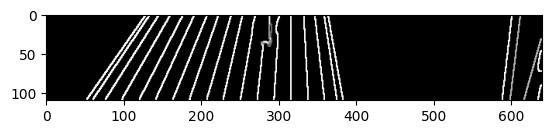

In [60]:
plt.imshow(edges, cmap='gray', vmin=0, vmax=255)


In [9]:
pre_r - pre_l

154.8503541540967

In [23]:
if __name__ == "__main__":
    cap = cv2.VideoCapture("./record_1.avi")
    while(cap.isOpened()):
        _, frame = cap.read()
        #====================segment==============================
        # center, img_show = lane_detection(frame)
        
        cv2.imshow("img_show", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

: 

TypeError: Image data of dtype object cannot be converted to float

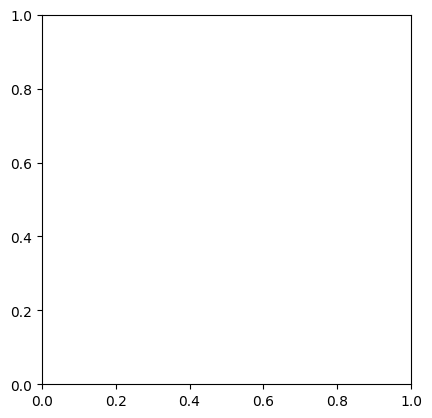

In [84]:
plt.imshow(frame)
